In [1]:
import pandas as pd
import vertica_python
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import os
import scipy
from scipy.stats import ttest_ind
import scipy.stats as stats

In [2]:
colors = ["windows blue", "amber", "greyish", "faded green", "dusty purple"]
xkcd = sns.xkcd_palette(colors)
sns.set_context("poster", font_scale=1.2)

In [3]:
username = os.getenv('VERTICA_USERNAME')
password = os.getenv('VERTICA_PASSWORD')
conn_info = {'host': 'warehouse.analytics.edx.org',
             'port': 5433,
             'user': username,
             'password': password,
             'database': 'warehouse',
             'read_timeout': 600,
             'unicode_error': 'strict',
             'ssl': False}

In [218]:
biz_stats_age = """

SELECT
    (2016-user_year_of_birth) AS age,
    CASE
    WHEN first_enrollment_time >= '2016-01-01' THEN '2016'
    WHEN first_enrollment_time BETWEEN '2015-01-01' AND '2015-12-31' THEN '2015'
    WHEN first_enrollment_time BETWEEN '2014-01-01' AND '2014-12-31' THEN '2014'
    END AS enrollment_range,
    CASE WHEN e.program_type IS NULL THEN 'N/A' ELSE e.program_type END AS program_type,
    count(1) AS count_enrolls,
    SUM(CASE WHEN first_verified_enrollment_time IS NOT NULL THEN 1 ELSE 0 END) AS count_verifs
FROM
	production.d_user_course a
JOIN
(
	SELECT
		course_id
	FROM
		production.d_course_subjects
	WHERE
		subject_title = 'Business & Management'
		AND lower(course_id) NOT LIKE '%demo%'
) b
ON a.course_id = b.course_id
LEFT JOIN production.d_course c
ON a.course_id = c.course_id
JOIN production.d_user d 
ON a.user_id = d.user_id
LEFT JOIN production.d_program_course e
on b.course_id = e.course_id
group by 1,2,3

"""

In [219]:
biz_stats_education = """

SELECT
    user_level_of_education AS education_level,
    CASE
    WHEN first_enrollment_time >= '2016-01-01' THEN '2016'
    WHEN first_enrollment_time BETWEEN '2015-01-01' AND '2015-12-31' THEN '2015'
    WHEN first_enrollment_time BETWEEN '2014-01-01' AND '2014-12-31' THEN '2014'
    END AS enrollment_range,
    CASE WHEN e.program_type IS NULL THEN 'N/A' ELSE e.program_type END AS program_type,
    count(1) AS count_enrolls,
    SUM(CASE WHEN first_verified_enrollment_time IS NOT NULL THEN 1 ELSE 0 END) AS count_verifs
FROM
	production.d_user_course a
JOIN
(
	SELECT
		course_id
	FROM
		production.d_course_subjects
	WHERE
		subject_title = 'Business & Management'
		AND lower(course_id) NOT LIKE '%demo%'
) b
ON a.course_id = b.course_id
LEFT JOIN production.d_course c
ON a.course_id = c.course_id
JOIN production.d_user d 
ON a.user_id = d.user_id
LEFT JOIN production.d_program_course e
on b.course_id = e.course_id
group by 1,2,3
"""

In [220]:
biz_stats_country = """

SELECT
    user_last_location_country_code AS user_country,
    CASE
    WHEN first_enrollment_time >= '2016-01-01' THEN '2016'
    WHEN first_enrollment_time BETWEEN '2015-01-01' AND '2015-12-31' THEN '2015'
    WHEN first_enrollment_time BETWEEN '2014-01-01' AND '2014-12-31' THEN '2014'
    END AS enrollment_range,
    CASE WHEN e.program_type IS NULL THEN 'N/A' ELSE e.program_type END AS program_type,
    count(1) AS count_enrolls,
    SUM(CASE WHEN first_verified_enrollment_time IS NOT NULL THEN 1 ELSE 0 END) AS count_verifs
FROM
	production.d_user_course a
JOIN
(
	SELECT
		course_id
	FROM
		production.d_course_subjects
	WHERE
		subject_title = 'Business & Management'
		AND lower(course_id) NOT LIKE '%demo%'
) b
ON a.course_id = b.course_id
LEFT JOIN production.d_course c
ON a.course_id = c.course_id
JOIN production.d_user d 
ON a.user_id = d.user_id
LEFT JOIN production.d_program_course e
on b.course_id = e.course_id
group by 1,2,3
"""

In [148]:
biz_stats_user_courses = """
SELECT
count_enrolls,
COUNT(1) AS count_users
FROM
(
SELECT
    a.user_id,
    count(1) AS count_enrolls,
    SUM(CASE WHEN first_verified_enrollment_time IS NOT NULL THEN 1 ELSE 0 END) AS count_verifs
FROM
	production.d_user_course a
JOIN
(
	SELECT
		course_id
	FROM
		production.d_course_subjects
	WHERE
		subject_title = 'Business & Management'
		AND lower(course_id) NOT LIKE '%demo%'
) b
ON a.course_id = b.course_id
LEFT JOIN production.d_course c
ON a.course_id = c.course_id
JOIN production.d_user d 
ON a.user_id = d.user_id
group by 1
) a
group by 1
"""

In [221]:
connection = vertica_python.connect(**conn_info)

cur = connection.cursor('dict')
cur.execute(biz_stats_age)
extract = cur.fetchall()
biz_stats_age_df = pd.DataFrame(extract)

cur = connection.cursor('dict')
cur.execute(biz_stats_country)
extract = cur.fetchall()
biz_stats_country_df = pd.DataFrame(extract)

cur = connection.cursor('dict')
cur.execute(biz_stats_education)
extract = cur.fetchall()
biz_stats_education_df = pd.DataFrame(extract)

cur = connection.cursor('dict')
cur.execute(biz_stats_user_courses)
extract = cur.fetchall()
biz_stats_user_courses_df = pd.DataFrame(extract)


connection.close()

In [65]:
sns.set_context("poster", font_scale=1)

In [185]:
def gen_plots(df, dimension, value, top_n, year='', program='', palette='Set1'):
    
    metric_title = ''
    
    if(program != ''):
        df = df[df.program_type == program]
        metric_title = program + '_'
    if(year != ''):
        df = df[df.enrollment_range == year]
        metric_title = metric_title + year + '_'
    if (value == 'count_enrolls'):
        metric_title = metric_title + 'enrollments'
    else:
        metric_title = metric_title + 'verifications'
        
    agg_df = df.groupby(dimension).sum().reset_index().sort_values(value, ascending=False).head(top_n)
    ax = sns.factorplot(data=agg_df, x=dimension, y=value, kind='bar', size = 10, palette=palette)
    ax.set(title = 'Business & Management, %s, by %s' % (metric_title, dimension), 
           xlabel=dimension, ylabel=metric_title)
    print df.groupby(dimension).sum().sort_values(
    value, ascending=False).head(top_n)[value]*100.0/(df.sum()[value]*1.0)

In [228]:
def wavg(group, avg_name, weight_name):
    """ http://stackoverflow.com/questions/10951341/pandas-dataframe-aggregate-function-using-multiple-columns
    In rare instance, we may not have weights, so just return the mean. Customize this if your business case
    should return otherwise.
    """
    d = group[avg_name]
    w = group[weight_name]
    try:
        return (d * w).sum() / w.sum()
    except ZeroDivisionError:
        return d.mean()

In [233]:
biz_stats_age_df.head()

,age,count_enrolls,count_verifs,enrollment_range,program_type
0,4.0,66,0,2016,XSeries
1,19.0,364,4,2014,N/A
2,86.0,10,0,2015,N/A
3,41.0,18,0,2015,XSeries
4,76.0,2,0,2016,MicroMasters


In [252]:
#wavg(biz_stats_age_df['enrollment_range'], biz_stats_age_df['age'], biz_stats_age_df['count_enrolls'])
age_df = pd.DataFrame()
temp_df = pd.DataFrame()
age_df['mean_age'] = biz_stats_age_df.groupby('enrollment_range').apply(wavg, "age", "count_enrolls")
age_df['type'] = 'enrollment'
#print biz_stats_age_df.groupby('enrollment_range').apply(wavg, "age", "count_verifs")
temp_df['mean_age'] = biz_stats_age_df.groupby('enrollment_range').apply(wavg, "age", "count_verifs")
temp_df['type'] = 'verification'
age_df = age_df.append(temp_df)



In [253]:
age_df

,mean_age,type
enrollment_range,,
2014,29.178958,enrollment
2015,28.430557,enrollment
2016,27.627855,enrollment
2014,33.237374,verification
2015,34.264151,verification
2016,33.987208,verification


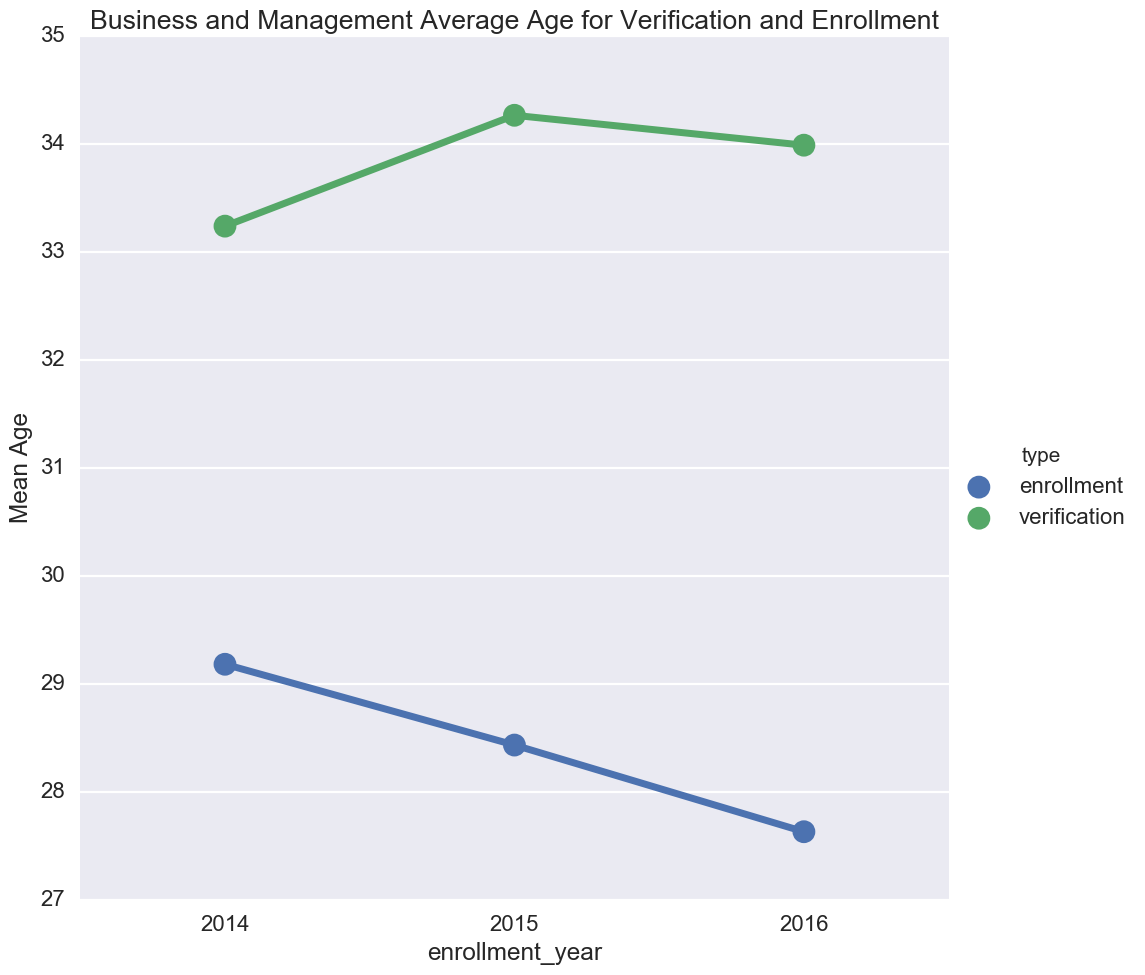

In [257]:
ax = sns.factorplot(data=age_df.reset_index(), x='enrollment_range', y='mean_age', kind='point',hue='type', size=10)
ax.set(title='Business and Management Average Age for Verification and Enrollment', xlabel='enrollment_year', ylabel='Mean Age')

In [225]:
biz_stats_education_df.groupby('enrollment_range').sum()['count_enrolls']*100.0/biz_stats_education_df.sum()['count_enrolls']

enrollment_range
2014     1.806030
2015    10.725616
2016    87.378055
Name: count_enrolls, dtype: float64

education_level
b     35.500462
m     27.412096
hs    14.316545
      10.570769
a      4.882938
Name: count_enrolls, dtype: float64
education_level
b     37.336452
m     37.289046
hs     9.171355
a      5.214588
       4.411858
Name: count_verifs, dtype: float64
user_country
US         18.071097
IN         11.719652
UNKNOWN     4.489123
GB          3.340183
BR          3.122230
CA          2.888170
MX          2.759708
CO          2.567621
DE          2.195746
PE          2.177386
Name: count_enrolls, dtype: float64
user_country
US    23.095885
IN     5.401049
HT     4.497187
GB     3.574363
PE     3.555401
CA     3.331016
BR     3.289931
MX     3.185639
DE     3.176158
CO     2.863283
Name: count_verifs, dtype: float64


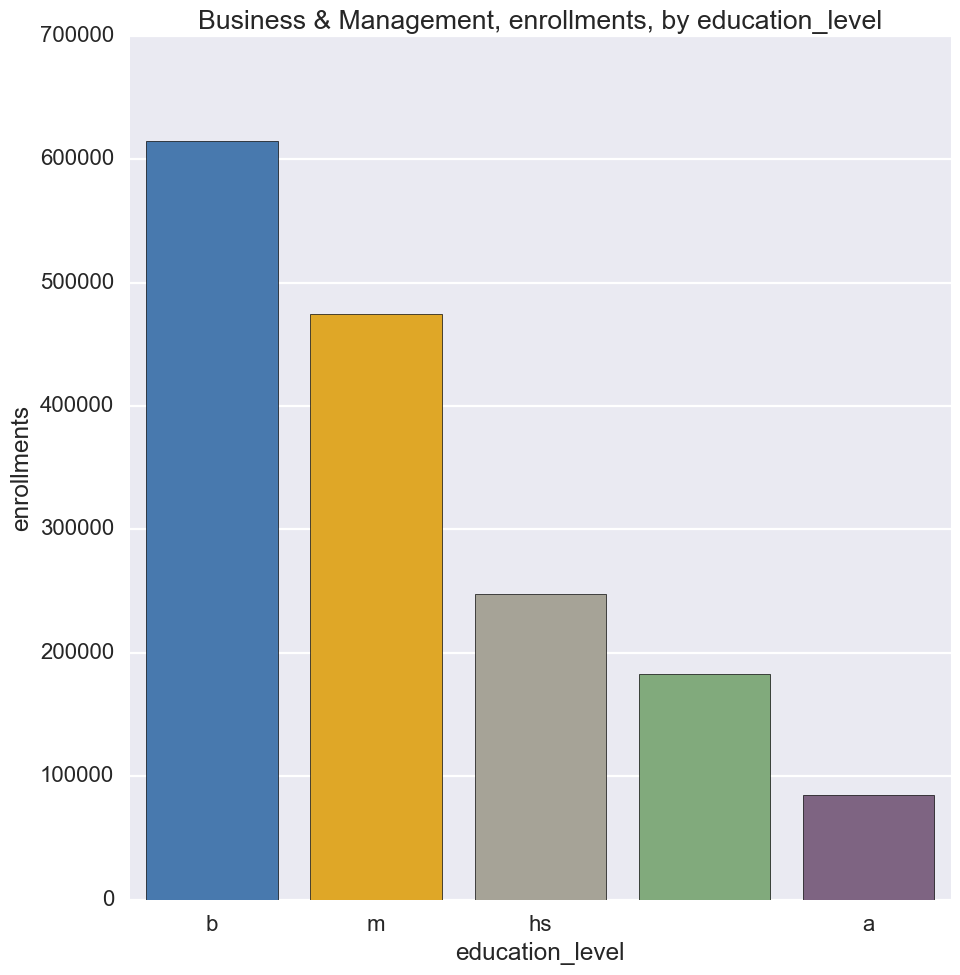

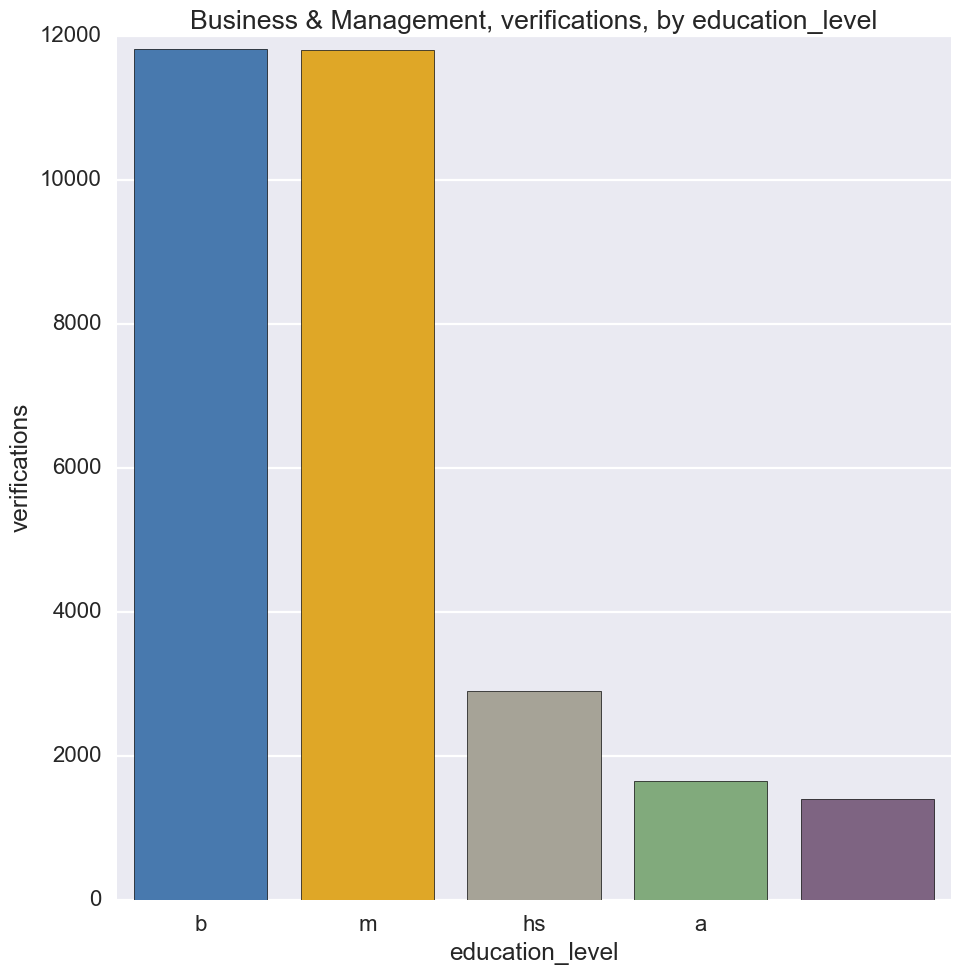

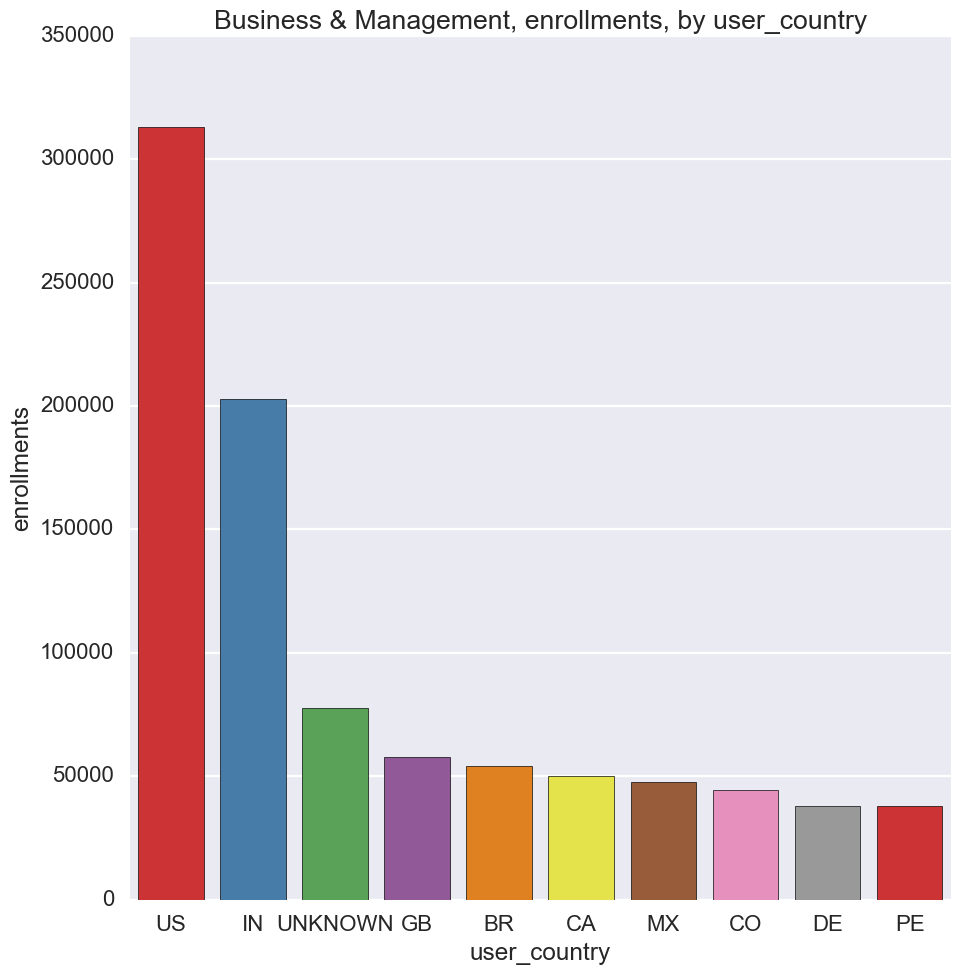

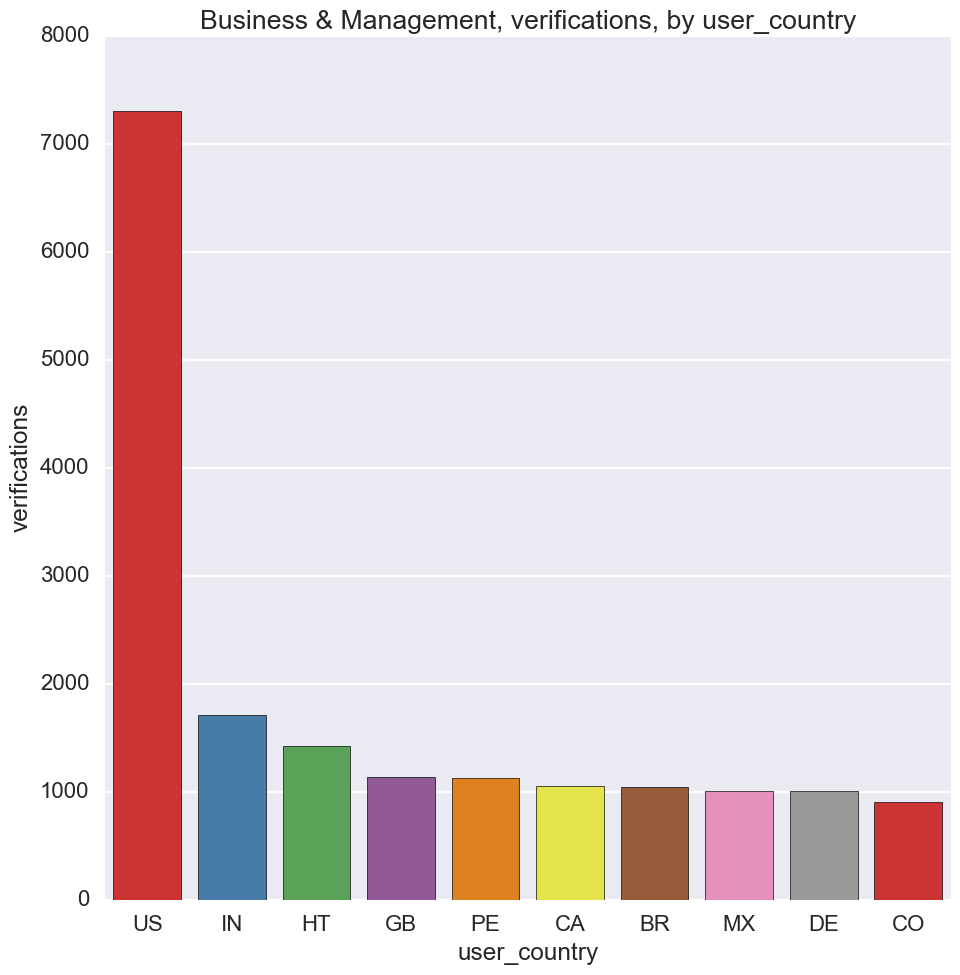

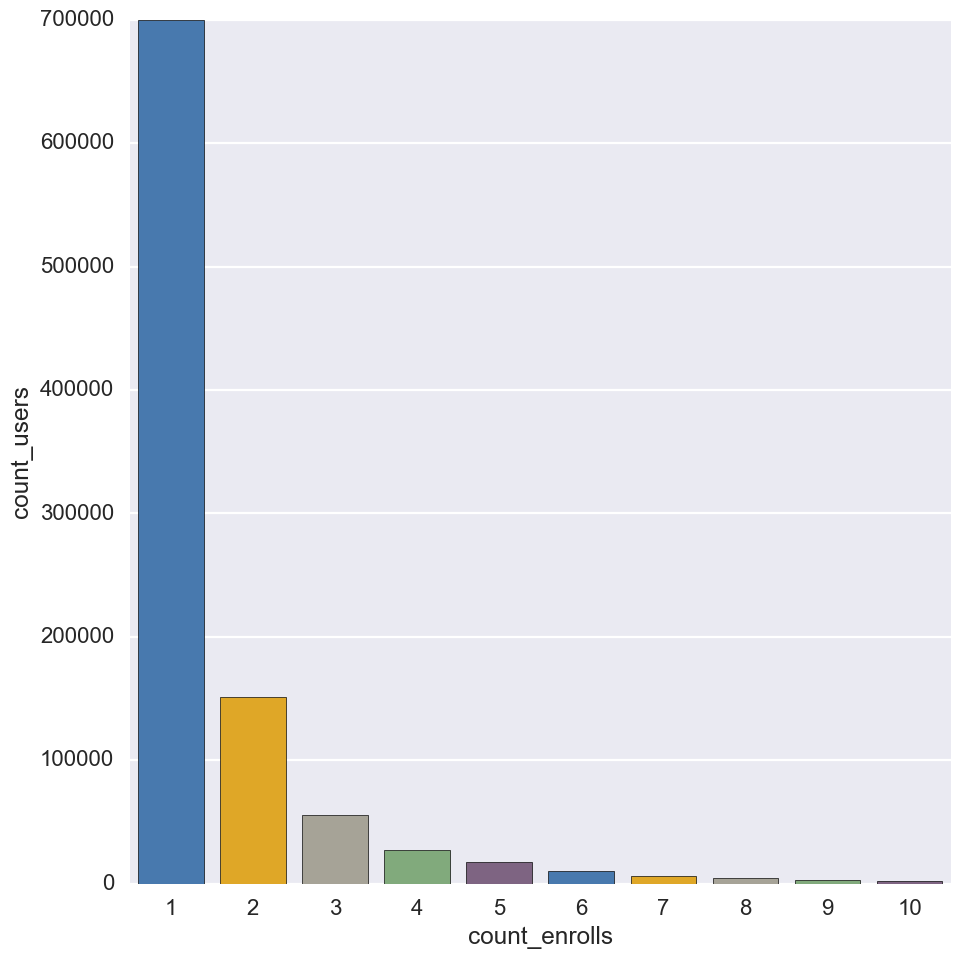

In [187]:
gen_plots(biz_stats_education_df, 'education_level', 'count_enrolls', 5, palette=xkcd)
gen_plots(biz_stats_education_df, 'education_level', 'count_verifs', 5, palette=xkcd)
gen_plots(biz_stats_country_df, 'user_country', 'count_enrolls', 10)
gen_plots(biz_stats_country_df, 'user_country', 'count_verifs', 10)


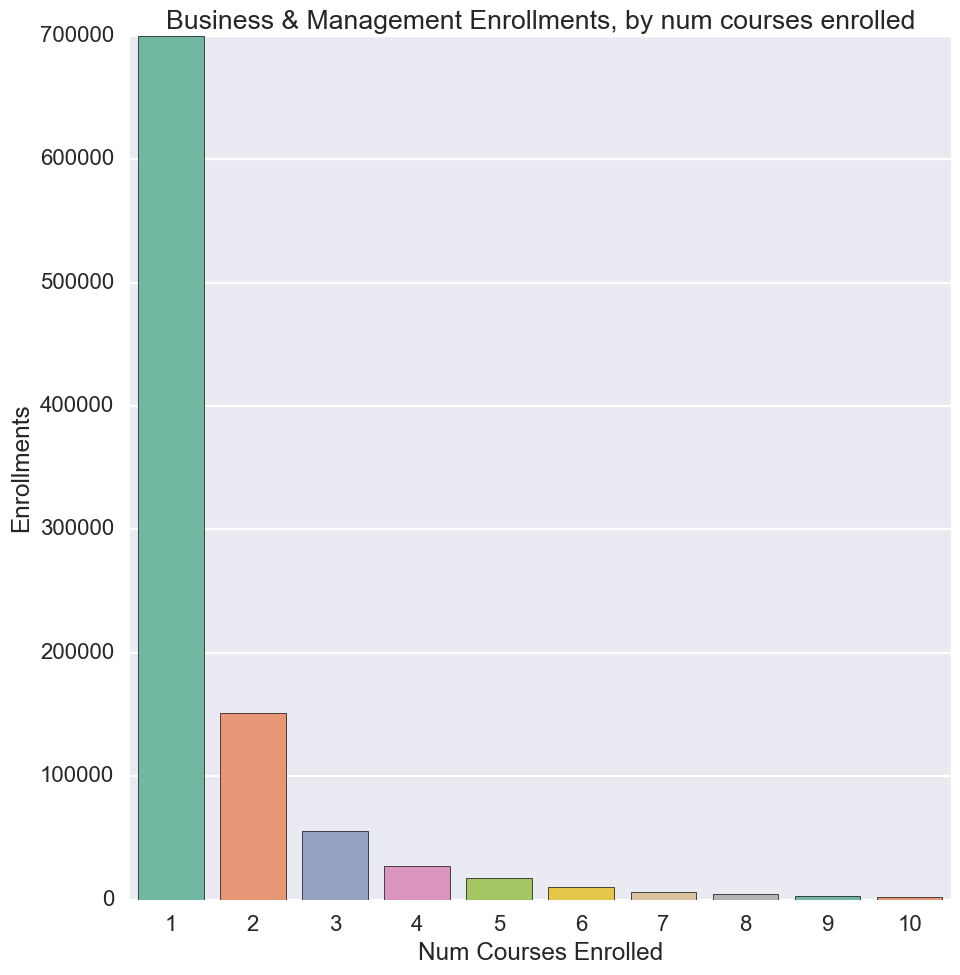

In [190]:
ax = sns.factorplot(data=biz_stats_user_courses_df.sort_values('count_users',ascending=False).head(10),
               x='count_enrolls', y='count_users', kind='bar', size = 10, palette="Set2")
ax.set(title='Business & Management Enrollments, by num courses enrolled', xlabel='Num Courses Enrolled', ylabel='Enrollments' )

education_level
b     35.765273
m     27.260599
hs    14.125141
      10.795783
a      5.012174
Name: count_enrolls, dtype: float64
education_level
b     37.652300
m     37.335043
hs     8.950690
a      5.231361
       4.488845
Name: count_verifs, dtype: float64
user_country
US         17.485158
IN         11.804363
UNKNOWN     4.624508
GB          3.312442
BR          3.196678
CA          2.870858
MX          2.740425
CO          2.670847
PE          2.247169
DE          2.191005
Name: count_enrolls, dtype: float64
user_country
US    22.639981
IN     5.130109
HT     4.792602
PE     3.726079
GB     3.496574
BR     3.348071
MX     3.260319
CA     3.256944
DE     3.186068
CO     3.007189
Name: count_verifs, dtype: float64


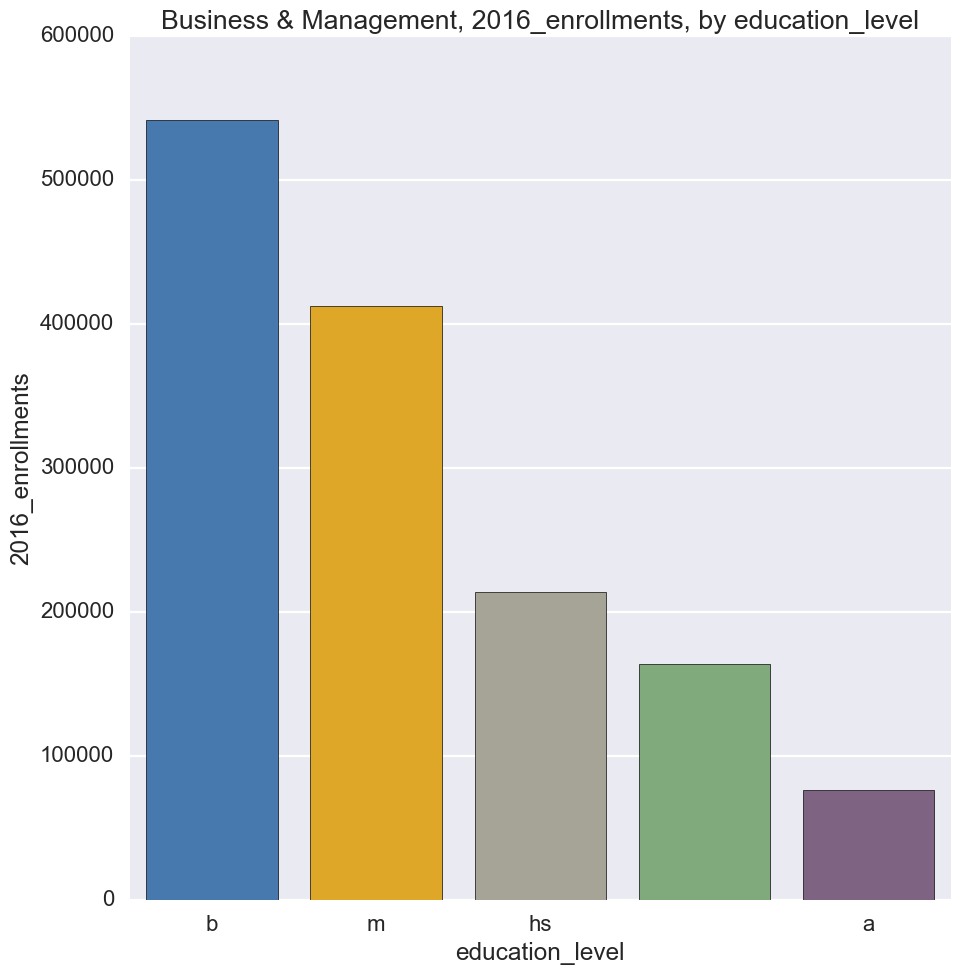

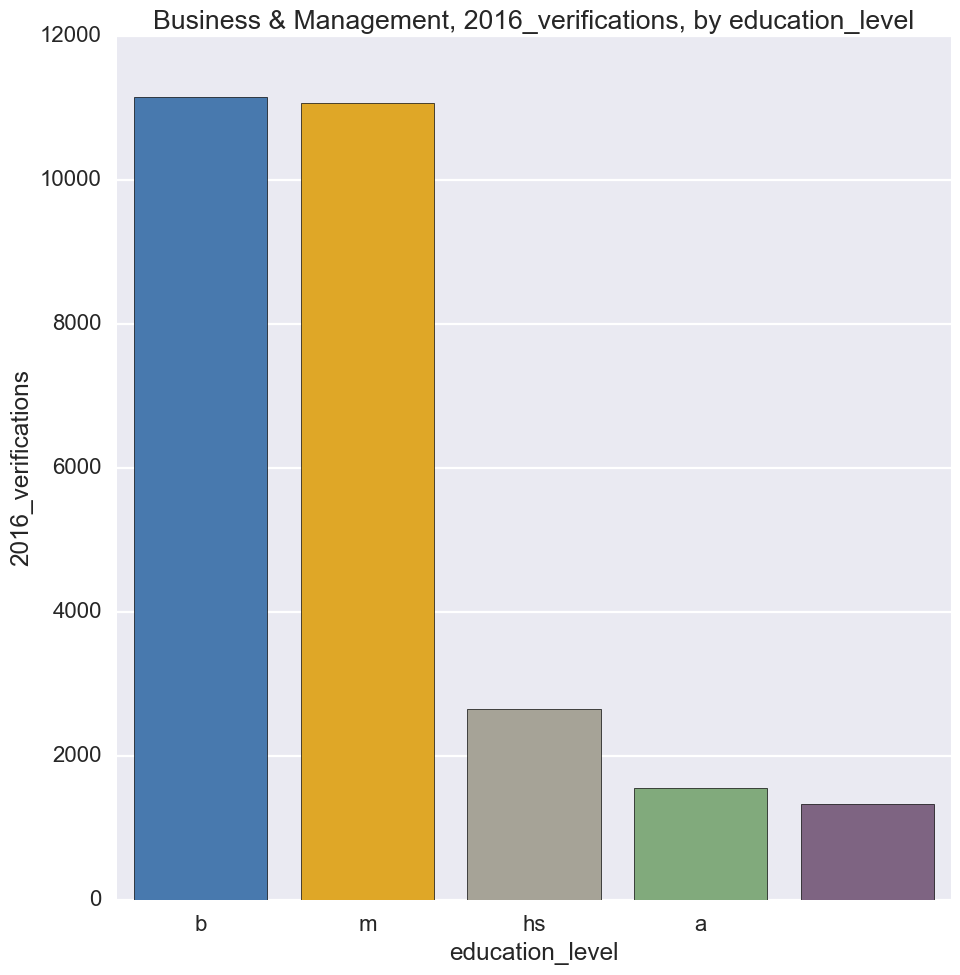

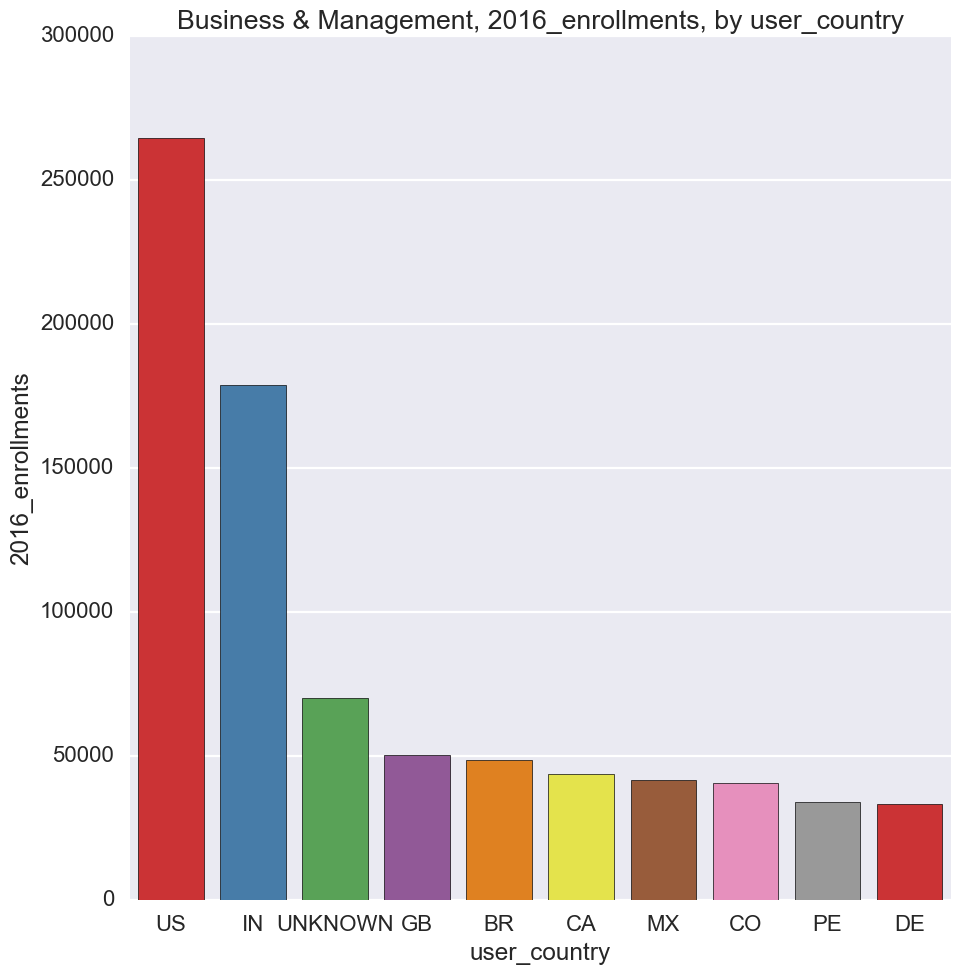

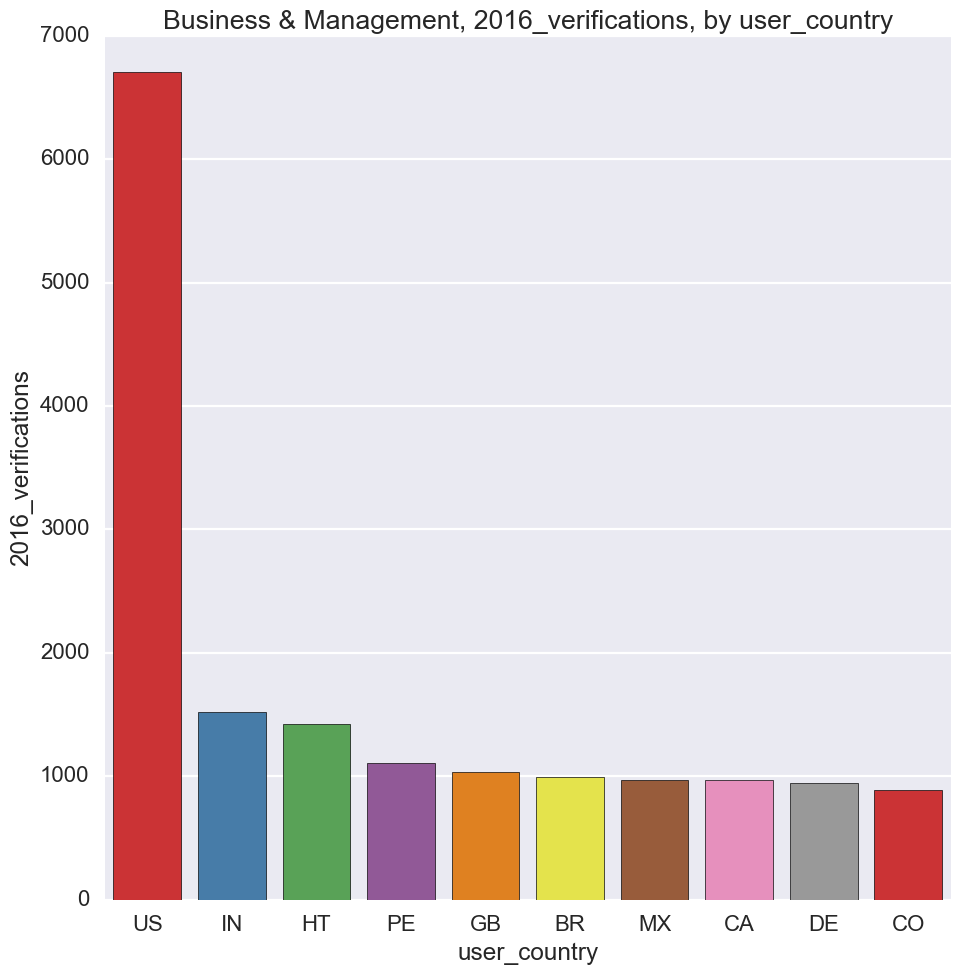

In [210]:
gen_plots(biz_stats_education_df, 'education_level', 'count_enrolls', 5, '2016', palette=xkcd)
gen_plots(biz_stats_education_df, 'education_level', 'count_verifs', 5,'2016', palette=xkcd)
gen_plots(biz_stats_country_df, 'user_country', 'count_enrolls', 10,'2016')
gen_plots(biz_stats_country_df, 'user_country', 'count_verifs', 10,'2016')


education_level
b     40.235200
m     28.719595
hs    12.394462
       8.159111
a      4.573952
Name: count_enrolls, dtype: float64
education_level
b     46.168537
m     37.861065
hs     6.135116
       4.034376
a      2.458821
Name: count_verifs, dtype: float64
user_country
US         16.502287
IN         10.695799
UNKNOWN     5.277540
FR          3.176827
BR          3.083853
CA          2.723892
GB          2.635315
CO          2.455649
MX          2.411046
EG          2.079983
Name: count_enrolls, dtype: float64
user_country
US         34.471234
UNKNOWN     3.891143
CA          3.676295
IN          3.604679
DE          3.174982
ES          3.151110
MX          2.888518
BR          2.793029
CN          2.339460
FR          2.267844
Name: count_verifs, dtype: float64


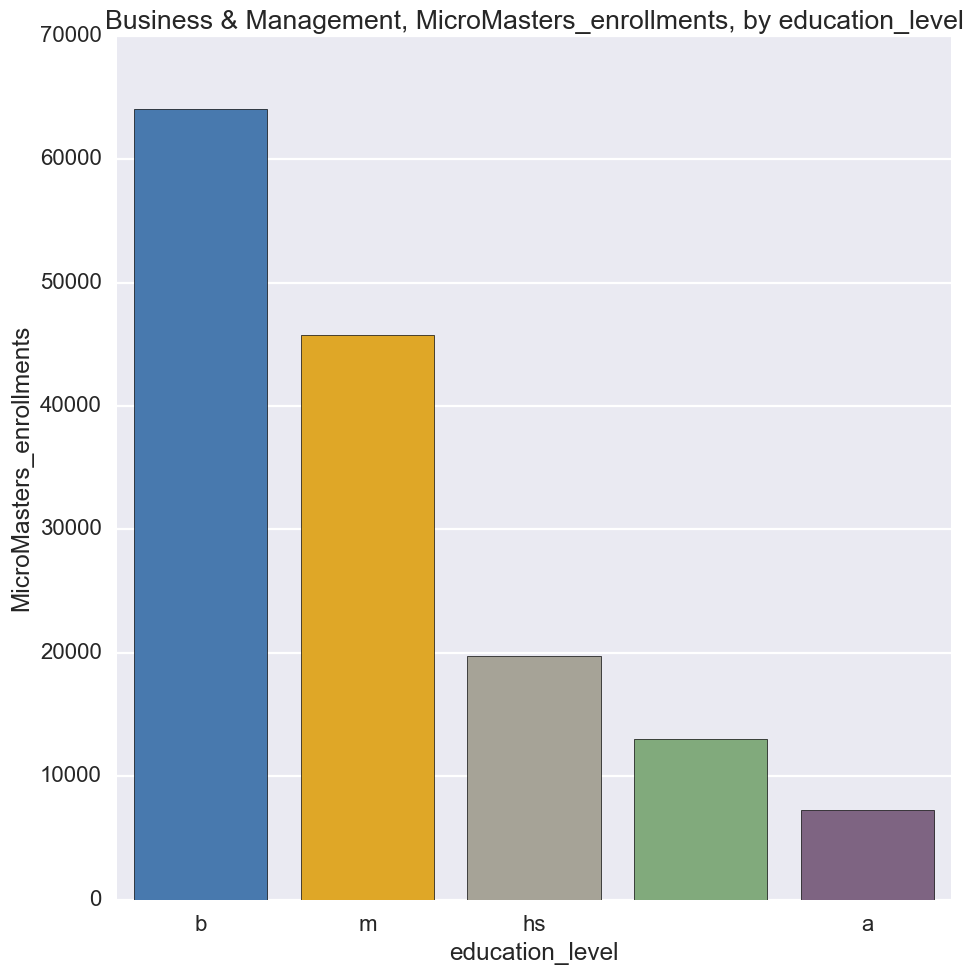

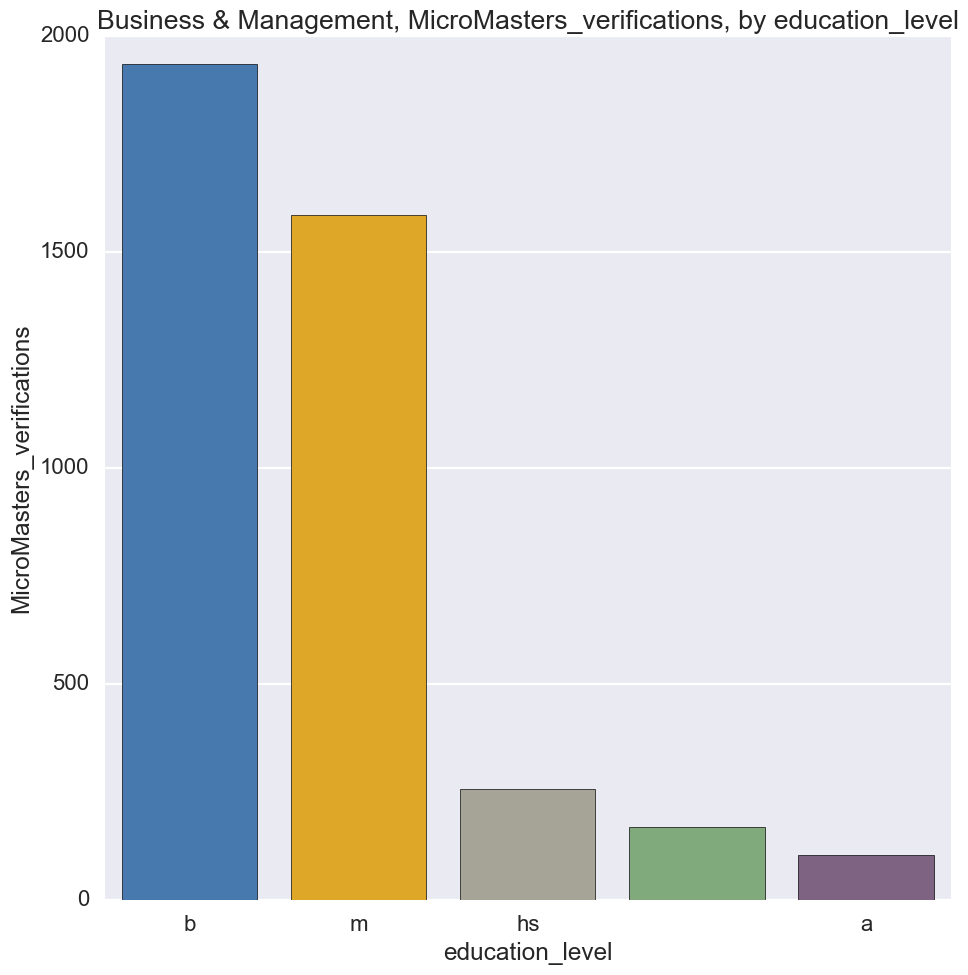

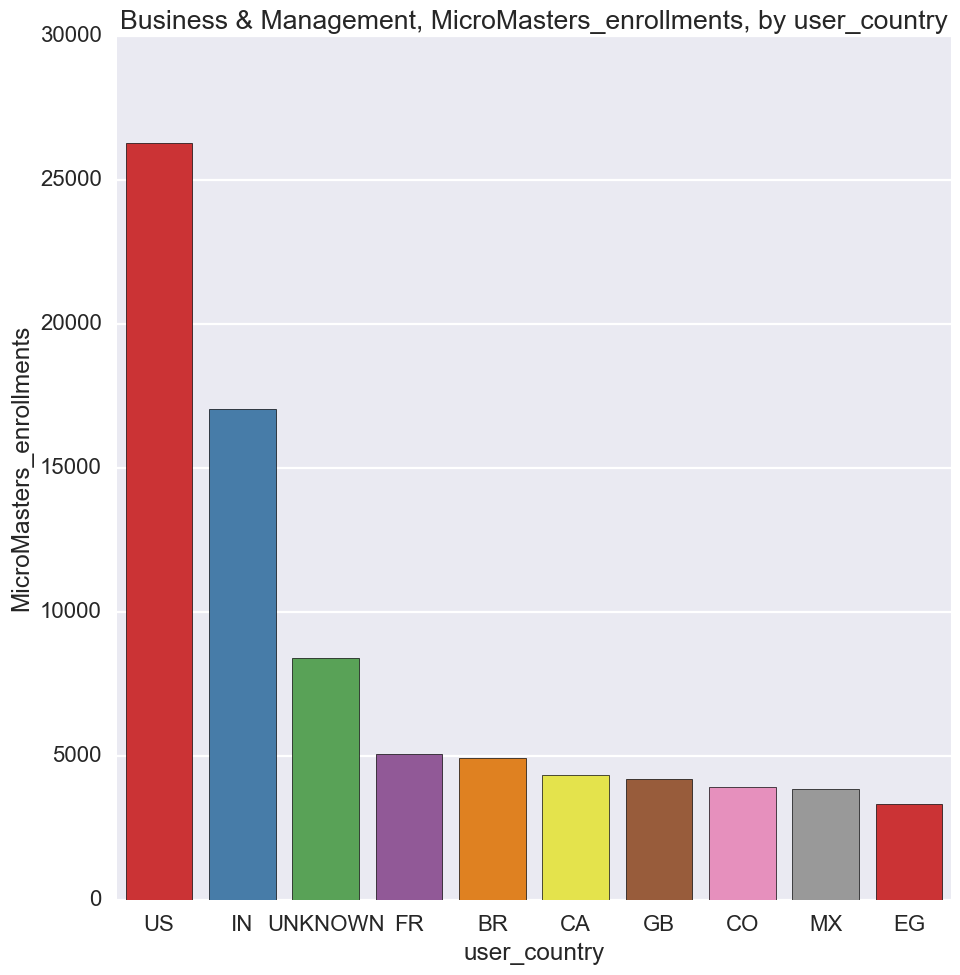

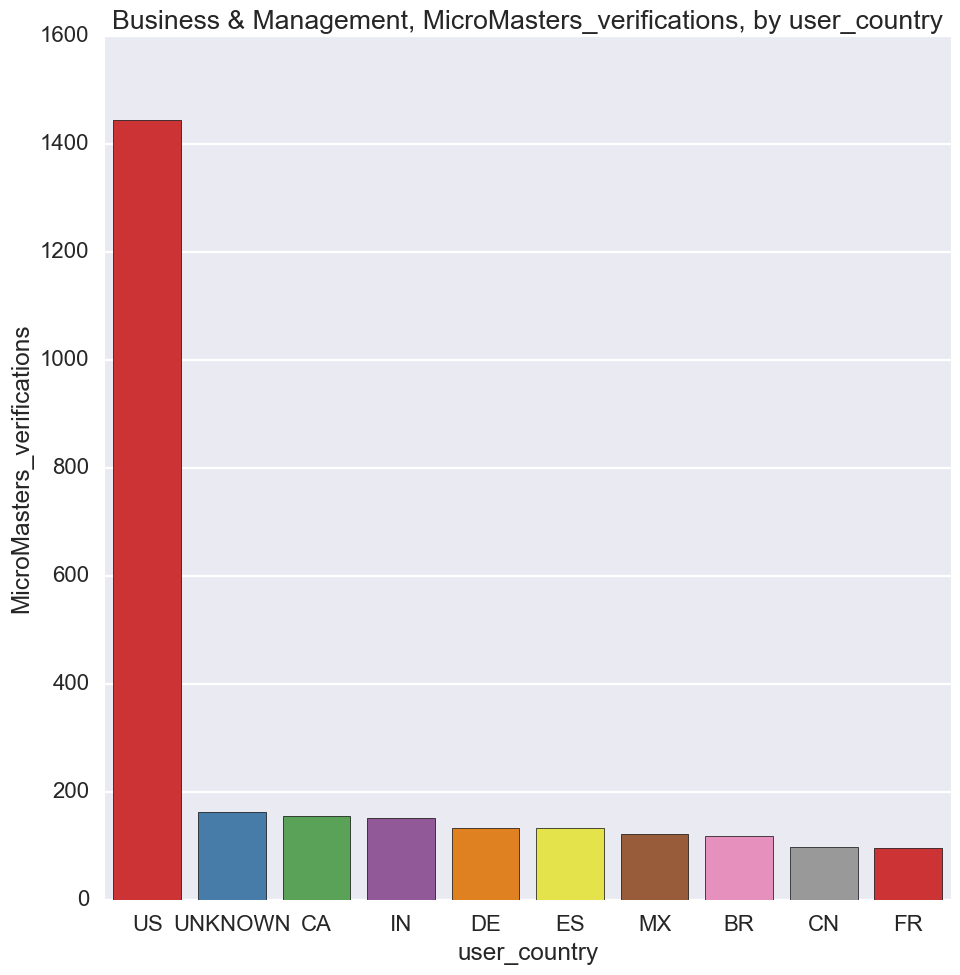

In [214]:
gen_plots(biz_stats_education_df, 'education_level', 'count_enrolls', 5, program='MicroMasters', palette=xkcd)
gen_plots(biz_stats_education_df, 'education_level', 'count_verifs', 5, program='MicroMasters', palette=xkcd)
gen_plots(biz_stats_country_df, 'user_country', 'count_enrolls', 10, program='MicroMasters')
gen_plots(biz_stats_country_df, 'user_country', 'count_verifs',  10, program='MicroMasters')
